# Little Language Model
## DanteGPT

This notebook is a simple implementation of a **Transformer** architecture. The model is trained on the text of Dante's **Divina Commedia**. The model is then used to generate text.

### Downloading and Saving Text Data from a URL

This code snippet downloads the full text of *La Divina Commedia* by Dante Alighieri from a given URL and saves it to a local file named `divina.txt`. 

#### Steps Involved

1. **Define the URL and File Name**:
   - `url`: The web address pointing to the text file of *La Divina Commedia*.
   - `file`: The name of the file where the downloaded text will be saved.

2. **Downloading the File**:
   - `requests.get(url)`: Sends an HTTP GET request to the URL, fetching the contents of the file.
   - `response`: Stores the HTTP response, which contains the text data in its `.text` attribute.

3. **Saving the Data Locally**:
   - Opens `divina.txt` in write mode with UTF-8 encoding to ensure proper handling of special characters.
   - Writes the contents from `response.text` into `divina.txt`.

#### Example Output
After running this code, the text of *La Divina Commedia* will be saved locally in `divina.txt`. This allows further processing or analysis of the text, such as text mining or language modeling.

#### Important Notes
- **Encoding**: UTF-8 encoding is specified to handle any Italian characters correctly.
- **Internet Access**: Running this code requires an internet connection to download the text file from the URL.
  
This setup is commonly used in Natural Language Processing (NLP) projects for importing and preparing text data for analysis.

In [1]:
import requests

url = 'https://dmf.unicatt.it/~della/pythoncourse18/commedia.txt'
file = 'divina.txt'
response = requests.get(url)
with open(file, 'w', encoding='utf-8') as f:
    f.write(response.text)

### Preparing Text Data for Processing

In this section, we load, encode, and decode the text data from *La Divina Commedia* to facilitate further analysis. 

#### Steps Involved

1. **Loading the Text Data**:
   - `text = open(file, 'r', encoding='utf-8').read()`: Reads the content of `divina.txt` (previously downloaded) as a single string, with UTF-8 encoding to ensure that special characters are handled correctly.

2. **Creating a Vocabulary**:
   - `vocab = sorted(list(set(text)))`: Builds a sorted list of unique characters in the text. This vocabulary will allow each character to be mapped to a unique integer index, which is essential for encoding the text.

3. **Defining Encoding and Decoding Functions**:
   - `encode = lambda s: [vocab.index(c) for c in s]`: Encodes a string `s` into a list of integers by mapping each character to its index in `vocab`.
   - `decode = lambda l: "".join([vocab[c] for c in l])`: Decodes a list of integers `l` back into a string by mapping each integer index to its corresponding character in `vocab`.

#### Example Usage

- `encode("Dante")` would produce a list of integers representing the indices of the characters in the vocabulary.
- `decode([0, 1, 2, 3])` would convert the list of indices back into the corresponding characters.

#### Importance

This encoding and decoding step is essential for preparing the text data in a way that can be processed by machine learning models, such as neural networks. By working with integer indices, we can easily convert text data into a format suitable for input to a model, and we can interpret model outputs by converting indices back into readable text.

In [2]:
text = open(file, 'r', encoding='utf-8').read()
vocab = sorted(list(set(text)))
encode = lambda s: [vocab.index(c) for c in s]
decode = lambda l: "".join([vocab[c] for c in l]) 

In [3]:
ids = encode("Nel mezzo del cammin di nostra vita")
txt = decode(ids)
print(f"ids: {ids}")
print(f"txt: {txt}")

ids: [24, 39, 45, 1, 46, 39, 58, 58, 48, 1, 38, 39, 45, 1, 37, 35, 46, 46, 43, 47, 1, 38, 43, 1, 47, 48, 52, 53, 51, 35, 1, 55, 43, 53, 35]
txt: Nel mezzo del cammin di nostra vita


### Importing the necessary libraries

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F

### Splitting the Text Data into Training and Validation Sets

To prepare the data for training a model, we divide the encoded text into training and validation sets. 

#### Steps Involved

1. **Setting the Split Point**:
   - `x = int(0.9 * len(text))`: We set `x` to represent 90% of the length of the text. This will be the split point between the training and validation data. A 90-10 split is commonly used, allowing the model to learn from most of the data while holding back a portion to evaluate its performance.

2. **Encoding and Converting to Tensor**:
   - `text = torch.tensor(encode(text), dtype=torch.long)`: The entire text is encoded into integer indices and then converted to a PyTorch tensor of type `long`. This tensor format is efficient and compatible with PyTorch models.

3. **Creating Training and Validation Sets**:
   - `train, val = text[:x], text[x:]`: The first 90% of the text (up to index `x`) is assigned to `train`, while the remaining 10% is assigned to `val`.

#### Importance

Dividing the data into training and validation sets is a critical step in machine learning, as it allows us to evaluate the model’s generalization ability on unseen data. The training set is used to fit the model, while the validation set helps assess its performance and guide tuning decisions.

In [5]:
x = int(0.9*len(text))
text = torch.tensor(encode(text), dtype=torch.long)
train, val = text[:x], text[x:]

### Generating Batches for Training and Validation

The `get_batch` function is designed to generate small batches of input (`x`) and target (`y`) tensors, which are used to train a transformer model. The function handles both training and validation data, depending on the specified `split` parameter, and outputs tensors moved to the appropriate device (CPU or GPU).

#### Key Parameters

- **`batch_size`**: This defines the number of sequences processed simultaneously, enhancing parallel processing. Here, it is set to 32.
- **`block_size`**: This represents the maximum sequence length or context window size, defining how many tokens each input sequence can see to make predictions.

#### Device Selection

The code detects if a GPU (`cuda`) is available and uses it if possible; otherwise, it defaults to the CPU (`cpu`). This ensures compatibility with different hardware setups.

#### Function Details

The `get_batch` function takes a `split` parameter, which specifies whether to generate data from the training or validation set. Here's a breakdown of the process:

1. **Data Selection**: `data` is assigned to either the `train` or `val` dataset based on the specified split.
2. **Random Sequence Selection**: A tensor `ix` of random starting indices is generated. These indices mark the starting points for each sequence in the batch.
3. **Input and Target Tensors**:
   - `x`: For each index `i` in `ix`, a block of `block_size` tokens starting at `i` is selected.
   - `y`: Target tokens are created by shifting the `x` sequence one position forward, allowing the model to predict the next token in the sequence.
4. **Device Assignment**: Both `x` and `y` are moved to the specified device, making them ready for model input.

#### Example Usage

The call `get_batch('train')` generates a batch of training data with `xb` and `yb` representing the input and target tensors, respectively. This function is essential for training the transformer model, as it ensures that data is prepared in the correct format and efficiently moved to the computation device.

In [6]:
from typing import Literal, Tuple

batch_size = 32 # batch_size -> how many independent sequences will we process in parallel?
block_size = 8 # block_size -> the maximum context length for predictions

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

def get_batch(split: Literal['train', 'val']) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generate a small batch of data of inputs x and targets y
    """
    data = train if split == 'train' else val  
    ix = torch.randint(len(data) - block_size, (batch_size,)) 
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

xb, yb = get_batch('train')

device: cuda


### Implementing the Head Class for Multi-Head Attention

This section defines the `Head` class, a foundational component of a multi-head attention mechanism in transformer architectures. The class encapsulates the operations needed to compute scaled dot-product attention, including the linear transformations and masking necessary for autoregressive processing.

#### Class Initialization

The `Head` class inherits from `nn.Module`, and its `__init__` method sets up the primary components:

- **`head_size`**: This defines the dimensionality of each attention head's output.
- **`key`, `query`, and `value` Linear Layers**: These layers transform the input data into key, query, and value vectors, essential for calculating attention scores. Each transformation outputs vectors of size `head_size`.
- **Lower Triangular Mask (`self.tril`)**: The attention mask, represented as a lower triangular matrix, ensures that each position in the sequence only attends to previous positions, which is crucial for autoregressive tasks like language modeling.
- **Dropout Layer**: Dropout helps regularize the model by randomly dropping attention weights during training, reducing the likelihood of overfitting.

#### Forward Method

The `forward` method defines how data passes through the `Head` layer. Here’s a breakdown of each step:

1. **Input Shape & Linear Transformations**: The input `x` of shape `(B, T, C)` (where `B` is the batch size, `T` is the sequence length, and `C` is the embedding size) is transformed into keys, queries, and values.
   - `k`, `q`, and `v` represent the transformed key, query, and value matrices, respectively.

2. **Attention Weight Calculation**:
   - The query and key vectors are multiplied to compute the attention scores (`wei`), which are scaled by `sqrt(head_size)` for stability.
   - The mask (`self.tril`) is applied to enforce autoregressive behavior, setting future positions to `-inf`, ensuring the model can only attend to previous positions in the sequence.
   - `F.softmax` converts the attention scores into a probability distribution along the last dimension.

3. **Attention Output**:
   - The weighted attention matrix is calculated by performing a batch matrix multiplication (`wei @ v`), combining the attention scores with the values.
   - Dropout is applied to the attention scores to further regularize the model.

The output of this `Head` class is a weighted sum of values, where each value’s contribution depends on the computed attention weights, enabling the model to focus on relevant parts of the sequence based on the query and key representations.

In [7]:
class Head(nn.Module):
    def __init__(self, head_size, embed_size, block_size, dropout=0.05):
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(2, 1) / self.head_size ** 0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=2)
        wei = self.dropout(wei)
        return wei @ v

### Demonstrating Masked Self-Attention with Triangular Matrix Masking

This code snippet demonstrates a simplified version of a self-attention mechanism, using random tensors as `query` and `value` matrices. The purpose of the script is to show how attention weights are calculated and then masked with a triangular matrix to enforce causality, a key component in autoregressive tasks.

#### Step-by-Step Breakdown

1. **Initialize Query and Value Tensors**:
   - `q` and `v` are tensors with random integer values, simulating the query and value representations from a batch with 1 sequence, 3 tokens, and 3-dimensional embeddings.
   - Output:
     ```
     Query:
     [[...]]
     Value:
     [[...]]
     ```

2. **Calculate Weights**:
   - `wei = q @ v.transpose(2, 1) / 3 ** 0.5`: We compute attention weights by taking the dot product of the query and the transposed value tensor, then scale by the square root of the embedding size.
   - The result is a matrix of attention weights for each pair of tokens.

3. **Create and Apply the Mask**:
   - `tril = torch.tril(torch.ones(3, 3))`: Creates a lower triangular matrix of ones, allowing each token to attend only to previous tokens and itself.
   - `wei = wei.masked_fill(tril == 0, float('-inf'))`: Sets all positions above the main diagonal to `-inf` (using the mask) to prevent future tokens from being attended to, ensuring a causal (autoregressive) attention mechanism.

4. **Apply Softmax to Weights**:
   - `F.softmax(wei, dim=2)`: Converts the masked weights into probabilities, where any weight of `-inf` becomes 0 after the softmax operation. This step allows the model to weigh each token's importance proportionally while respecting causality.

#### Example Output
```plaintext
Query:
 [[...]]
Value:
 [[...]]
weights:
 [[...]]
Triangular Metrics:
 [[...]]
Masked Weights:
 [[...]]
Softmax ( e^-inf = 0 ):
 [[...]]
```

#### Importance

The triangular mask is essential in autoregressive language models, ensuring each position in the sequence only attends to current and preceding positions. This technique prevents "cheating" by masking out future information, making it a fundamental part of sequence prediction and generation tasks.

In [8]:
q = torch.randint(10, (1, 3, 3))
v = torch.randint(10, (1, 3, 3))
print("Query:\n",q)
print("Value:\n",v)
wei = q@v.transpose(2, 1)/3**0.5
print("weights:\n", wei)
tril = torch.tril(torch.ones(3, 3))
print("Triangular Metrics:\n",tril)
wei = wei.masked_fill(tril == 0, float('-inf'))
print("Masked Weights\n", wei)
print("Softmax ( e^-inf = 0 )\n", F.softmax(wei, dim=2))

Query:
 tensor([[[7, 3, 3],
         [6, 2, 0],
         [7, 6, 6]]])
Value:
 tensor([[[6, 2, 4],
         [7, 0, 4],
         [2, 1, 0]]])
weights:
 tensor([[[34.6410, 35.2184,  9.8150],
         [23.0940, 24.2487,  8.0829],
         [45.0333, 42.1466, 11.5470]]])
Triangular Metrics:
 tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
Masked Weights
 tensor([[[34.6410,    -inf,    -inf],
         [23.0940, 24.2487,    -inf],
         [45.0333, 42.1466, 11.5470]]])
Softmax ( e^-inf = 0 )
 tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.3963e-01, 7.6037e-01, 0.0000e+00],
         [9.4719e-01, 5.2812e-02, 2.7134e-15]]])


### Multi-Head Attention Layer

This code defines a `MultiHeadAttention` class, which is a core component in transformer architectures. Multi-head attention allows the model to focus on different parts of the input sequence simultaneously, capturing multiple types of relationships among tokens.

#### Class Attributes

- **`self.sa_head`**: This is a `ModuleList` containing multiple instances of the `Head` class, each of which performs a self-attention operation on the input. Each head learns a different attention pattern, capturing diverse relationships in the data.
- **`self.proj`**: A linear layer that projects the concatenated outputs of all heads back to the original embedding size. This layer helps aggregate the multi-head attention information into a single tensor of the expected size.
- **`self.dropout`**: A dropout layer applied after the projection, helping prevent overfitting by randomly setting some of the output units to zero during training.

#### Forward Pass

1. **Concatenation of Heads**:
   - `torch.cat([head(x) for head in self.sa_head], dim=-1)`: The input `x` is passed through each head in `self.sa_head`, and their outputs are concatenated along the last dimension.
   - This concatenation effectively gathers information from multiple attention patterns learned by each head.

2. **Projection and Dropout**:
   - `self.proj(x)`: The concatenated tensor is passed through the projection layer to transform it back to the embedding size, ensuring dimensional consistency.
   - `self.dropout(...)`: Dropout is applied to the projected output, providing regularization to the model.

#### Benefits of Multi-Head Attention

By having multiple heads, the model can learn different aspects of the input sequence’s structure, such as positional relationships or dependencies between specific tokens. Each head learns its own query, key, and value transformations, enabling richer representations and enhancing the model's ability to capture complex dependencies.

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, head_size, embed_size, block_size, num_head, dropout=0.05):
        super().__init__()
        self.sa_head = nn.ModuleList([Head(head_size, embed_size, block_size, dropout) for _ in range(num_head)])
        self.proj = nn.Linear(embed_size, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.cat([head(x) for head in self.sa_head], dim=-1)
        return self.dropout(self.proj(x))

### Block Class: Transformer Block

This code defines a `Block` class, which represents a single transformer block, an essential building block for transformer architectures like GPT or BERT. A transformer block consists of two key components: multi-head self-attention and a feed-forward network, each followed by a residual connection and layer normalization.

#### Class Attributes

1. **`self.multihead`**: This is an instance of the `MultiHeadAttention` class that performs multi-head self-attention. It allows the model to focus on different parts of the input sequence simultaneously.
2. **`self.ff`**: This is an instance of the `FeedForward` class, which applies a simple feed-forward network to the output of the attention mechanism.
3. **`self.ll1` and `self.ll2`**: These are Layer Normalization layers applied before each sub-layer (multi-head attention and feed-forward network). Layer normalization helps stabilize and speed up training by normalizing the input across the features.

#### Forward Pass

1. **Multi-Head Attention with Residual Connection**:
   - `x = x + self.multihead(self.ll1(x))`: The input `x` is first passed through layer normalization (`self.ll1(x)`), then through the multi-head attention (`self.multihead(...)`), and finally a residual connection is added by summing the original `x` with the output of the attention mechanism.

2. **Feed-Forward Network with Residual Connection**:
   - `x = x + self.ff(self.ll2(x))`: The output from the previous step is passed through the second layer normalization (`self.ll2(x)`), followed by the feed-forward network (`self.ff(...)`). Again, a residual connection is added, allowing the original input to flow through the network.

#### Summary of Components

- **Multi-Head Attention**: Captures different relationships and dependencies in the input sequence.
- **Feed-Forward Network**: Transforms the output from the attention mechanism, providing additional complexity and enabling the model to learn more intricate patterns.
- **Layer Normalization**: Ensures stable and efficient training by normalizing the activations within each layer.
- **Residual Connections**: Allow gradients to flow more easily through the network, improving training dynamics and helping prevent vanishing gradient problems.

### Transformer Block Workflow
In essence, this transformer block works as follows:
1. Input is passed through the attention mechanism (after layer normalization).
2. Residual connection is added between the original input and the output of the attention mechanism.
3. The result is passed through the feed-forward network (after layer normalization).
4. Another residual connection is added between the original input and the output of the feed-forward network.

This modular structure is repeated multiple times in the transformer model, stacking several such blocks to create a deeper model capable of learning complex representations.

In [10]:
class FeedForward(nn.Module):
    def __init__(self, embed_size, dropout=0.05):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ff(x)
    
class Block(nn.Module):
    def __init__(self, head_size, embed_size, block_size, num_head, dropout=0.05):  # Reduced dropout
        super().__init__()
        head_size = embed_size // num_head
        self.multihead = MultiHeadAttention(head_size, embed_size, block_size, num_head, dropout)
        self.ff = FeedForward(embed_size, dropout)
        self.ll1 = nn.LayerNorm(embed_size)
        self.ll2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        x = x + self.multihead(self.ll1(x))
        return x + self.ff(self.ll2(x))

### LittleLanguageModel: Transformer-based Language Model

The `LittleLanguageModel` class is a neural network architecture designed for language modeling. It uses a transformer-based structure with attention layers to predict the next word in a sequence. It incorporates several key components, including token embeddings, positional embeddings, and multiple transformer blocks stacked together.

#### Key Components

1. **Token Embedding Table**:
   - `self.token_embedding_table = nn.Embedding(vocab_size, embed_size)`: This layer maps each token (word or character) in the vocabulary to a dense vector representation (embedding) of size `embed_size`.

2. **Positional Embedding**:
   - `self.positional_embedding = nn.Embedding(block_size, embed_size)`: This layer adds positional encodings to the input sequence, allowing the model to capture the order of the tokens, which is essential for language modeling.

3. **Transformer Blocks**:
   - `self.block = nn.Sequential(*[Block(head_size, embed_size, block_size, num_head, dropout) for _ in range(num_layers)])`: This is a stack of transformer blocks. Each block contains multi-head attention and feed-forward layers. The number of blocks (`num_layers`) can be adjusted.

4. **Linear Layer**:
   - `self.linear = nn.Linear(embed_size, vocab_size)`: After processing through the transformer blocks, the final embeddings are passed through a linear layer that projects the embedding space back to the vocabulary size. This generates logits, which can be used to calculate the probability of each token in the vocabulary.

5. **Layer Normalization**:
   - `self.layer_norm = nn.LayerNorm(embed_size)`: This layer normalizes the activations before passing them through the transformer blocks, helping improve training stability and convergence.

#### Forward Pass

The forward method defines how the input flows through the model:

1. **Embedding Lookup**:
   - `logits = self.token_embedding_table(idx)`: The input token indices (`idx`) are converted into token embeddings of size `embed_size`.

2. **Positional Encoding**:
   - `ps = self.positional_embedding(torch.arange(T, device=idx.device))`: Positional embeddings are added to the token embeddings to encode the order of the tokens in the sequence.

3. **Transformer Blocks**:
   - `x = logits + ps`: The token embeddings and positional encodings are summed.
   - `logits = self.linear(self.layer_norm(self.block(x)))`: The combined representation is passed through the transformer blocks followed by layer normalization and a final linear transformation to predict the next token.

4. **Loss Calculation**:
   - If `targets` (ground truth labels) are provided, the model computes the cross-entropy loss between the predicted logits and the true targets.

#### Generation (Sampling)

The `generate` method generates text one token at a time, based on an initial input sequence `idx`.

1. **Sampling Process**:
   - `crop_idx = idx[:, -block_size:].to(device)`: The model keeps track of the last `block_size` tokens in the input sequence to make predictions.
   - `logits, _ = self(crop_idx)`: The model generates logits (predicted token probabilities) for the next token.
   - `logits = logits[:, -1, :] / temperature`: The logits are scaled by a `temperature` factor. A higher temperature results in more random sampling, while a lower temperature makes the model more confident.
   - `probs = F.softmax(logits, dim=-1)`: The logits are converted to probabilities using the softmax function.
   - `idx_next = torch.multinomial(probs, num_samples=1).to(device)`: The model samples the next token based on the probability distribution.
   - `idx = torch.cat((idx, idx_next), dim=1)`: The generated token is appended to the input sequence, and the process repeats for `max_new_tokens` tokens.

#### Summary

- **Input**: The model takes in a sequence of token indices (`idx`) and generates predictions for the next token.
- **Training**: During training, the model computes the cross-entropy loss between the predicted logits and the true token labels.
- **Generation**: During generation, the model samples the next token based on the probabilities computed by the transformer and appends it to the input sequence.
  
The `LittleLanguageModel` uses a transformer architecture with multi-head attention to model language sequences and predict the next word or token. It allows for flexible training and text generation, making it suitable for various NLP tasks.

In [ ]:
class LittleLanguageModel(nn.Module):
    def __init__(self, vocab_size, head_size, embed_size, block_size, num_head, num_layers, dropout=0.05):  # Reduced dropout
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.positional_embedding = nn.Embedding(block_size, embed_size)
        self.linear = nn.Linear(embed_size, vocab_size)
        self.block = nn.Sequential(*[Block(head_size, embed_size, block_size, num_head, dropout) for _ in range(num_layers)])
        self.layer_norm = nn.LayerNorm(embed_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        logits = self.token_embedding_table(idx)  # (B, T, C)
        ps = self.positional_embedding(torch.arange(T, device=idx.device))
        x = logits + ps  # (B, T, C)
        logits = self.linear(self.layer_norm(self.block(x)))  # Improved LayerNorm positioning
        
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0):
        if temperature <= 0.0:
            raise ValueError("Temperature must be greater than zero for sampling.")
        
        if temperature == 0.0:
            return self(idx)[0].argmax(dim=-1)
        
        for _ in range(max_new_tokens):
            crop_idx = idx[:, -block_size:].to(device)
            logits, _ = self(crop_idx)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1).to(device)
            idx = torch.cat((idx, idx_next), dim=1)
        
        return idx

### Model Setup and Initialization

In this section, the transformer-based `LittleLanguageModel` is initialized with specific hyperparameters, followed by setting up the optimizer for training.

#### Parameters Definition

- **`embed_size = 512`**: This is the dimensionality of the token embeddings. A higher embedding size allows the model to capture more intricate relationships in the data but also increases the computational cost.
  
- **`num_head = 8`**: This specifies the number of attention heads in the multi-head attention mechanism. Multiple attention heads allow the model to attend to different parts of the input sequence simultaneously, improving its ability to learn diverse features.
  
- **`head_size = embed_size // num_head`**: The size of each attention head is calculated by dividing the `embed_size` by the number of heads. This ensures that the total embedding space is evenly split across the heads in the attention mechanism.
  
- **`num_layers = 6`**: The number of transformer layers stacked together. Each layer consists of multi-head attention followed by a feed-forward network. More layers can increase the model's capacity to learn complex representations but may also lead to overfitting and longer training times.
  
- **`vocab_size = len(vocab)`**: This defines the size of the vocabulary. It is determined by the number of unique characters or words in the dataset, which corresponds to the input and output space of the model.

#### Model Instantiation

- **`model = LittleLanguageModel(vocab_size, head_size, embed_size, block_size, num_head, num_layers).to(device)`**:
   - This line creates an instance of the `LittleLanguageModel` with the parameters defined above.
   - The model is moved to the device (`cuda` or `cpu`) based on availability of a GPU.

#### Optimizer Setup

- **`optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)`**:
   - This line initializes the optimizer using **AdamW**, which is a variant of the Adam optimizer that includes weight decay to reduce overfitting.
   - `model.parameters()` gives the optimizer access to all the trainable parameters of the model.
   - The learning rate is set to `1e-3`, which is a commonly used value for training deep learning models.

#### Summary

This setup initializes the `LittleLanguageModel` with appropriate hyperparameters, followed by configuring the AdamW optimizer. The model and optimizer are now ready for training.

In [ ]:
# Define the parameters
embed_size = 512                    # Example embedding size
num_head = 8                        # Example number of attention heads
head_size = embed_size // num_head  # Example size of each attention head
num_layers = 6                      # Example number of layers
vocab_size = len(vocab)             # Example vocabulary size

# Instantiate the model
model = LittleLanguageModel(vocab_size, head_size, embed_size, block_size, num_head, num_layers).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

### Training the Little Language Model

In this section, we define and execute the training process for the `LittleLanguageModel`. The `train_model` function handles both training and evaluation, updating the model weights based on the loss from the training data while periodically evaluating on the validation set.

#### `train_model` Function Overview

1. **Training and Validation Loss Tracking**:
   - The function accepts the model, optimizer, and other hyperparameters such as the number of epochs (`epochs`) and evaluation interval (`eval_interval`).
   - It tracks training and validation losses across epochs to monitor the performance of the model during training.

2. **Epoch Loop**:
   - For each epoch, the model is trained on the training data in mini-batches and periodically evaluated on the validation set.
   - Every `eval_interval` epochs, the model is set to evaluation mode using `model.eval()` to disable dropout and other training-specific behaviors. The loss is then calculated for both the training and validation datasets over 100 batches.
   - After evaluation, the model is set back to training mode using `model.train()`.

3. **Loss Calculation**:
   - For each batch, the model computes the output logits and compares them with the target labels to calculate the loss using **cross-entropy**.
   - The loss for both the training and validation sets is accumulated over 100 batches, and the average is logged.

4. **Gradient Computation and Parameter Update**:
   - During the training phase, for each mini-batch, the model computes the forward pass, calculates the loss, and performs backpropagation (`loss.backward()`) to compute the gradients.
   - The optimizer updates the model weights (`optimizer.step()`), applying the gradients.

5. **Learning Rate Scheduling**:
   - The learning rate is halved every 1000 epochs to gradually reduce the step size and stabilize training as the model approaches convergence.

#### Training Execution

- **`train_losses, val_losses = train_model(model, optimizer)`**: 
   - This line starts the training process and stores the resulting training and validation losses in `train_losses` and `val_losses`.
   - These losses can later be plotted or analyzed to understand how well the model is converging over time.

#### Summary

This function trains the `LittleLanguageModel` over a specified number of epochs, computes the loss for both training and validation sets, and adjusts the learning rate as needed. It provides feedback every `eval_interval` epochs and tracks the model's performance to ensure that the learning process is progressing correctly.

In [13]:
def train_model(model, optimizer, epochs=5000, eval_interval=100):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        if epoch % eval_interval == 0:
            model.eval()
            train_loss, val_loss = 0.0, 0.0
            with torch.no_grad():
                for _ in range(100):
                    x_train, y_train = get_batch('train')
                    x_val, y_val = get_batch('val')
                    _, train_batch_loss = model(x_train, y_train)
                    _, val_batch_loss = model(x_val, y_val)
                    train_loss += train_batch_loss.item()
                    val_loss += val_batch_loss.item()
            train_losses.append(train_loss / 100)
            val_losses.append(val_loss / 100)
            print(f"Epoch {epoch} | Train Loss: {train_loss / 100:.4f} | Val Loss: {val_loss / 100:.4f}")
            model.train()

        x_batch, y_batch = get_batch('train')
        optimizer.zero_grad(set_to_none=True)
        _, loss = model(x_batch, y_batch)
        loss.backward()
        optimizer.step()
        
        # Learning rate scheduler (e.g., halve every 1000 epochs)
        if epoch % 1000 == 0 and epoch > 0:
            for g in optimizer.param_groups:
                g['lr'] *= 0.5
    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(model, optimizer)

Epoch 0 | Train Loss: 4.4753 | Val Loss: 4.4765
Epoch 100 | Train Loss: 2.3680 | Val Loss: 2.3657
Epoch 200 | Train Loss: 2.2707 | Val Loss: 2.2468
Epoch 300 | Train Loss: 2.1758 | Val Loss: 2.1808
Epoch 400 | Train Loss: 2.1586 | Val Loss: 2.1143
Epoch 500 | Train Loss: 2.1263 | Val Loss: 2.1165
Epoch 600 | Train Loss: 2.1242 | Val Loss: 2.1093
Epoch 700 | Train Loss: 2.0875 | Val Loss: 2.0807
Epoch 800 | Train Loss: 2.1040 | Val Loss: 2.0884
Epoch 900 | Train Loss: 2.0877 | Val Loss: 2.0961
Epoch 1000 | Train Loss: 2.0802 | Val Loss: 2.0652
Epoch 1100 | Train Loss: 2.0257 | Val Loss: 1.9979
Epoch 1200 | Train Loss: 2.0309 | Val Loss: 2.0138
Epoch 1300 | Train Loss: 2.0171 | Val Loss: 2.0232
Epoch 1400 | Train Loss: 1.9927 | Val Loss: 1.9773
Epoch 1500 | Train Loss: 2.0052 | Val Loss: 1.9843
Epoch 1600 | Train Loss: 2.0044 | Val Loss: 1.9860
Epoch 1700 | Train Loss: 1.9923 | Val Loss: 1.9733
Epoch 1800 | Train Loss: 1.9759 | Val Loss: 1.9874
Epoch 1900 | Train Loss: 1.9868 | Val Loss:

### Plotting the Training and Validation Losses

The code snippet provided generates a plot that visualizes the training and validation losses over time, helping to track the model's learning progress and identify potential overfitting or underfitting. 

#### `plot_losses` Function Overview

1. **Plot Setup**:
   - The function begins by creating a figure with a specified size using `plt.figure(figsize=(10, 5))`.
   - Then, it plots both the training and validation losses using `plt.plot(train_losses)` and `plt.plot(val_losses)`, respectively. These losses are tracked over the evaluation intervals.
   
2. **Labels and Legends**:
   - The `xlabel` and `ylabel` set the axes to indicate the number of evaluation intervals and the loss values, respectively.
   - `plt.legend()` adds a legend to distinguish between the training and validation loss curves.
   
3. **Title and Display**:
   - The plot is titled "Training and Validation Loss over Time" using `plt.title()`, providing context for the graph.
   - Finally, `plt.show()` displays the plot.

#### Visualizing the Losses

By calling `plot_losses(train_losses, val_losses)`, you will be able to see how the model's performance evolves. If the training loss decreases while the validation loss increases significantly, it could be a sign of overfitting. On the other hand, if both losses decrease gradually, the model is likely generalizing well.

This visualization is useful for evaluating the effectiveness of your training process and tuning your model's hyperparameters accordingly.

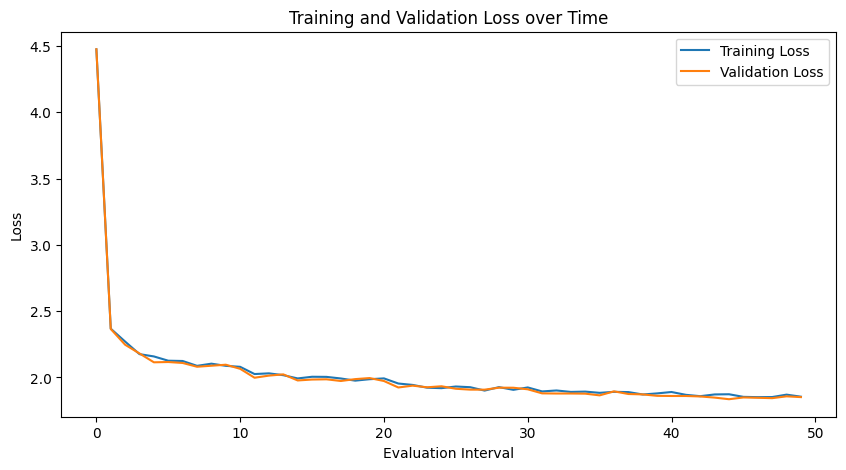

In [14]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss over Time')
    plt.show()

# Plot the losses
plot_losses(train_losses, val_losses)

### Generating Text Using the Model

The provided code snippet demonstrates how to generate text using a trained language model, starting from a given input sequence. Here's a breakdown of how the text generation works:

#### 1. **Encoding the Input**:
```python
ids = torch.tensor(encode("Nel mezzo del cammin di nostra vita"), dtype=torch.long).unsqueeze(0).to(device)
```
- **Input**: `"Nel mezzo del cammin di nostra vita"` is the starting text (in Italian).
- The text is encoded into integer tokens using the `encode` function, which maps each character in the string to its corresponding index in the vocabulary.
- `.unsqueeze(0)` adds a batch dimension to the tensor (since the model expects a batch of sequences).
- `.to(device)` ensures that the tensor is placed on the appropriate device (either CPU or GPU).

#### 2. **Generating New Tokens**:
```python
generated_ids = model.generate(ids, max_new_tokens=2000, temperature=1.0)
```
- **Text Generation**: The `generate` method of the `LittleLanguageModel` generates a sequence of new tokens based on the initial input `ids`.
- **Parameters**:
  - `max_new_tokens=2000`: Specifies that up to 2000 new tokens should be generated.
  - `temperature=1.0`: Controls the randomness of the predictions. A temperature of 1.0 means the model will sample from the distribution without scaling it (more random behavior). A lower temperature would make the model more deterministic, while a higher temperature would make it more random.

#### 3. **Decoding and Printing the Generated Text**:
```python
print(decode(generated_ids[0].tolist()))
```
- The generated token IDs are decoded back into human-readable text using the `decode` function. The `tolist()` converts the tensor to a Python list for decoding.
- Finally, the generated text is printed.

This will output a continuation of the initial input text, produced by the model based on the learned patterns and context.

In [19]:
ids = torch.tensor(encode("Nel mezzo del cammin di nostra vita"), dtype=torch.long).unsqueeze(0).to(device)
generated_ids = model.generate(ids, max_new_tokens=2000, temperature=0.8)

print(decode(generated_ids[0].tolist()))

Nel mezzo del cammin di nostra vita,

gensarà sona.

  Que sù di condò a l'a spoi sando tan duce le ne si genteri di Coi: "O vote,

confella,

  riviglio, sazza

piel si monace,

ha e divo acramori!";

  e Dietra, anota cal que le raggio memme diria, de lo fa testo con dura cio teme la liette savigne di iolo

che Giacetto.

  O e tra  tu tutto,

quel de questò

che quellio vegno

"Mace an il sento più la precro e non l'orto porto

la che la de griato: "Per la l'accaritta, l'amma chiuna;

e Ma dondi, into la la tus vi paeler lo gronda, e dità, cir avi sura lucatorno è valira, segi terno

dendo la certo tutti avresse, non le le cal farlo cietra odel sanza;

  'l guardo

dostro al palente e luri.

  Nol sembran hi del mate a contore,

  comma lo mondo, a villa

che d'al ginti;

  se rigoglio, quel da;

oco quiferta,

mor s'marebbe;

  umaede,

commo seso, tu poi, né nostapenti

a già, che e 'l titpasco.

  E per la pioci di quele che più intando a n'alla nostritre anche storichi Biaronò '